In [3]:
import tensorflow as tf
import json
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
dataset_folder = ""
sensitive_datafile = "/SensitiveDataset.json"
nonsensitive_datafile = "/NonSensitiveDataset.json"
dataList = []
sentences = []
labels = []

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  with open(os.path.join(dataset_folder, filename), 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords:
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    dataList.append([sentence, label])
loadDataset(sensitive_datafile)
loadDataset(nonsensitive_datafile)
random.shuffle(dataList)
print("Dataset Size: ", len(dataList))
for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])


vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = ""
training_size = 20000

training_sentences = sentences[0:training_size]
validation_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[0])
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences[0])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: username:quinton, password:arsenal14, email:quinton@aol.com, phone no:4770273038
Validation Dataset Size:  11576
Sample Validation Data: Sid (John Raitt) just hired superintendent Sleeptite Pajama Factory Cedar Rapids, Iowa. He soon falls Babe (Doris Day), worker factory member employee union's leadership. At company picnic become couple, Babe worries roles management labor will drive apart. She correct. The union pushing raise seven-and-one-half cents per hour bring line industry standard, factory's manager giving runaround. In retaliation, workers pull slow-down deliberately foul pajamas, Babe actually sabotages machinery, Sid fires her.
Meanwhile, Sid wondering secrets manager hiding locked account book. To end, takes Gladys (Carol Haney), boss' assistant, date local hot spot, "Hernando's Hideaway", despite insanely jealous boyfriend "Hine-sie" (Eddie Foy, Jr.). He gets Gladys drunk, state, lends key locked boo

In [4]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary()
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)



Size of word index: 103459
Saving the word index as JSON


In [5]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [6]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [8]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.999
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.Sequential([
    # Embedding - Turns positive integers (indexes) into dense vectors of fixed size (here embedding_dim = 32).
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # 1D convolution layer - filter size = 128, convolution window = 5, activation fn = ReLU
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    # Global average pooling operation (Flattening)
    tf.keras.layers.GlobalAveragePooling1D(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(24, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 32)            96000     
                                                                 
 conv1d (Conv1D)             (None, 56, 64)            10304     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 107889 (421.44 KB)
Trainable params: 107889 (421.44 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [9]:
num_epochs = 6

# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(
                        validation_padded,
                        validation_labels),
                    verbose=1)
                    #callbacks=[callbacks])

Epoch 1/6
625/625 [==============================] - 7s 10ms/step - loss: 0.0579 - accuracy: 0.9901 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 2/6
625/625 [==============================] - 4s 7ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0016 - val_accuracy: 0.9991
Epoch 3/6
625/625 [==============================] - 5s 7ms/step - loss: 8.0666e-04 - accuracy: 0.9998 - val_loss: 6.8954e-04 - val_accuracy: 0.9997
Epoch 4/6
625/625 [==============================] - 6s 10ms/step - loss: 3.8778e-04 - accuracy: 0.9998 - val_loss: 6.0003e-04 - val_accuracy: 0.9997
Epoch 5/6
625/625 [==============================] - 5s 8ms/step - loss: 2.8604e-04 - accuracy: 0.9999 - val_loss: 1.5256e-04 - val_accuracy: 1.0000
Epoch 6/6
625/625 [==============================] - 4s 7ms/step - loss: 9.9016e-05 - accuracy: 1.0000 - val_loss: 8.5462e-05 - val_accuracy: 1.0000


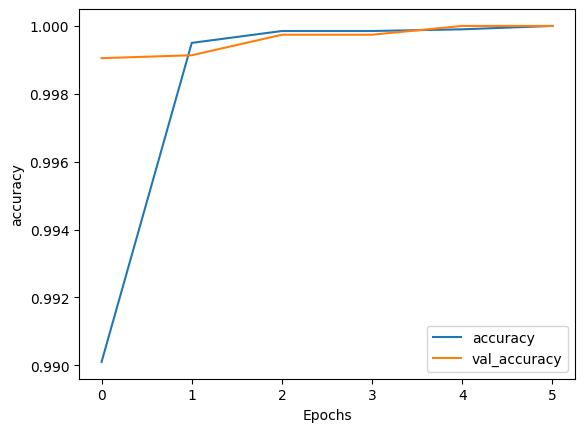

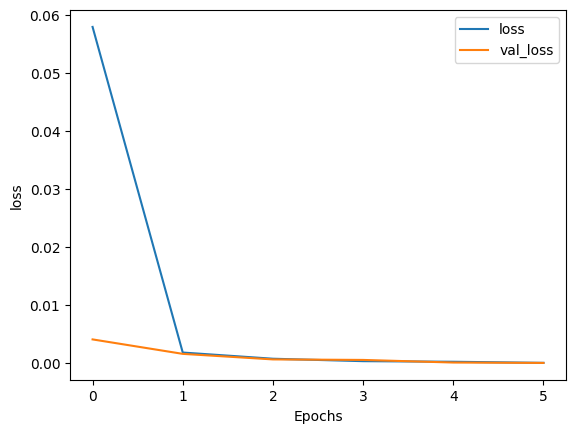

In [10]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Confusion Matrix
362/362 [==============================] - 2s 6ms/step
Accuracy for 2894 Test Data =  100.0
Accuracy for 5788 Test Data =  100.0
Accuracy for 8682 Test Data =  100.0
Accuracy for 11576 Test Data =  100.0


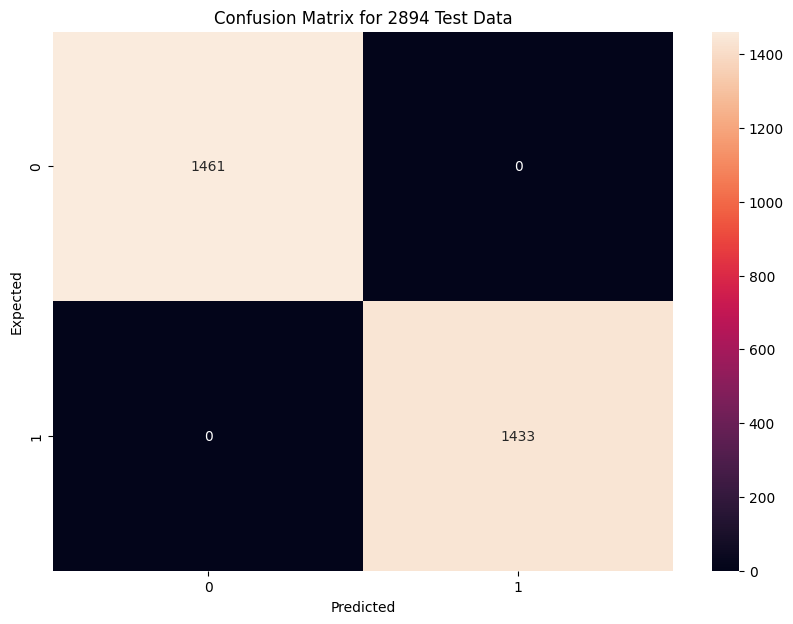

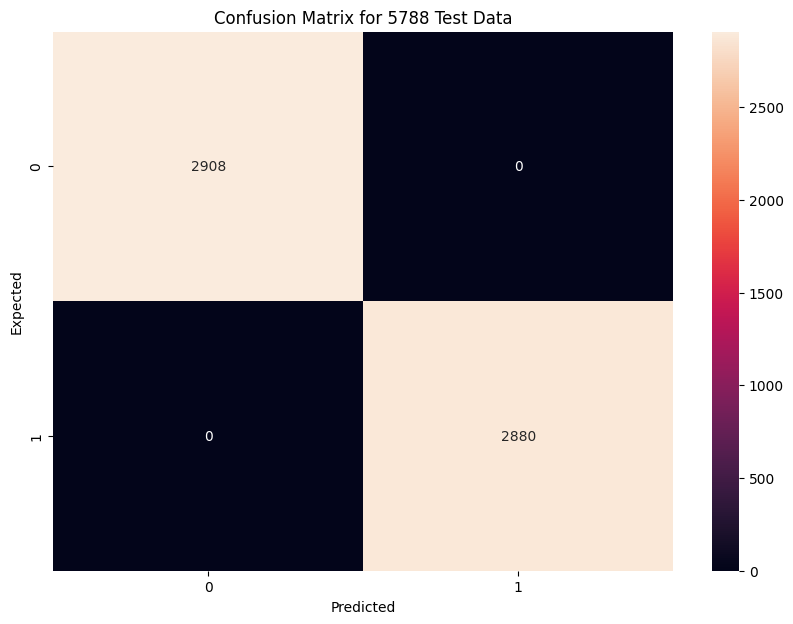

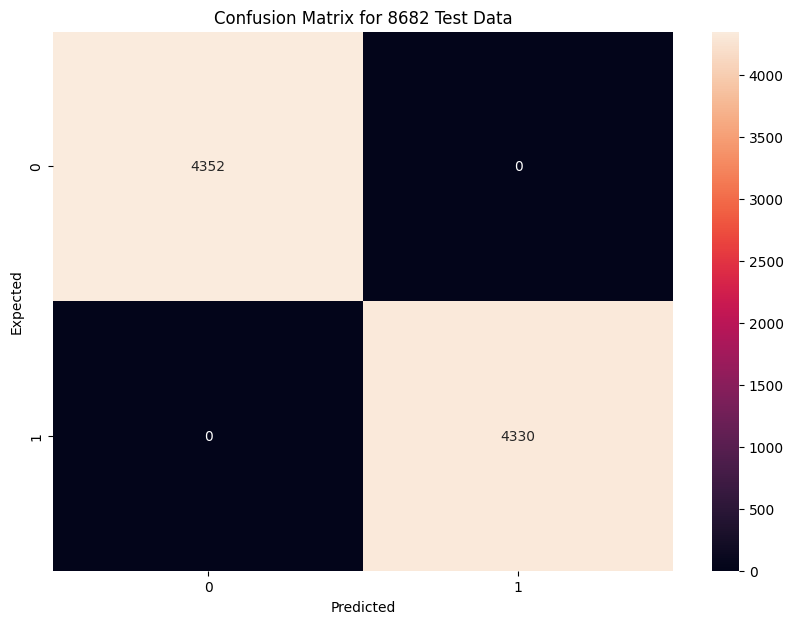

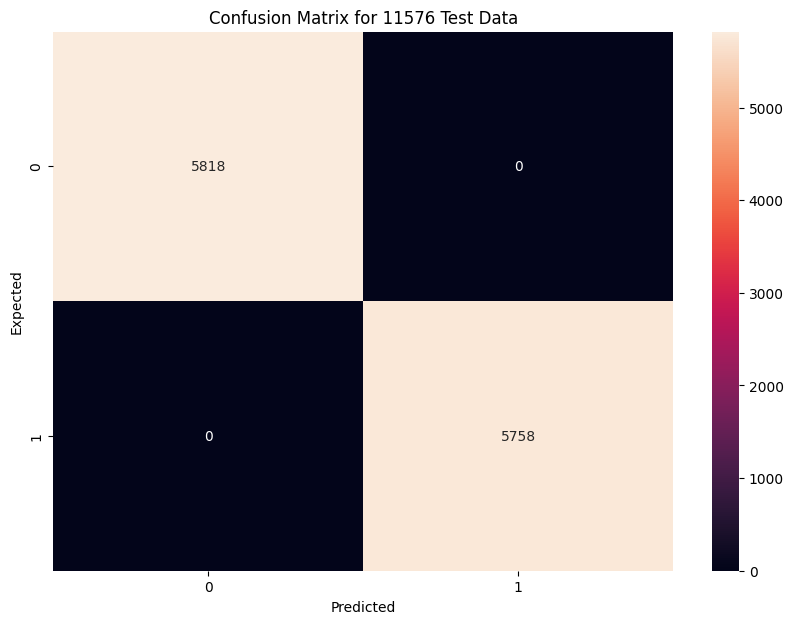

In [11]:
import seaborn
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
y_predicted_labels = y_predicted > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  cm = tf.math.confusion_matrix(labels=validation_labels[0:total],predictions=y_predicted_labels[0:total])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

In [12]:
# Sample examples
sentence = ["My credit card no is 124345346", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  if predictions[i][0]>0.5:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

1/1 [==============================] - 0s 74ms/step
0.95953447
Sensitive - My credit card no is 124345346
0.002434023
Non-Sensitive - game of thrones season finale showing this sunday night
